__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Ср 29 мар 2023 16:57:46 MSK


In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [4]:
# !ls -1 data

## считываем данные

In [5]:
data_file = 'data/data_land.pkl'

In [6]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

20944


,title,adr,latitude,longitude,priceM,ts
3988,"Участок 3,5 сот. (ИЖС)","Севастополь,Вербеновый пр., 5",44.561648,33.453558,3.90,2022-09-15 10:31:26.039
4485,"Участок 4,5 сот. (ИЖС)","Севастополь,ТИЗ Гранит",44.577567,33.591305,3.20,2022-09-16 15:10:34.059
9415,Участок 9 сот. (ИЖС),"Севастополь,ул. Журналиста Хамадана",44.569027,33.484325,8.10,2022-10-08 20:38:42.759


In [7]:
display(len(df))
df = df[ ~df['adr_orig'].isna() ].reset_index(drop=True)
display(len(df))

20944

18058

In [8]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['adr_orig'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [9]:
# берём объявления с геометкой
print(len(df))
df = df[ 
    ~( df['latitude'].isnull()| df['longitude'].isnull() ) 
].reset_index(drop=True)
print(len(df))

18058
18038


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038 entries, 0 to 18037
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               18038 non-null  object        
 1   price               18038 non-null  int64         
 2   obj_name            18038 non-null  object        
 3   adr_orig            18038 non-null  object        
 4   description         18038 non-null  object        
 5   avito_page          18038 non-null  int64         
 6   ts                  18038 non-null  datetime64[ns]
 7   place               18038 non-null  object        
 8   area                18038 non-null  float64       
 9   is_IJS              18038 non-null  bool          
 10  priceM              18038 non-null  float64       
 11  priceMU             18038 non-null  float64       
 12  area_size_category  18028 non-null  category      
 13  url                 18038 non-null  object    

In [11]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
800,Участок 15 сот. (ИЖС),"Севастополь,с. Широкое, Приозёрная ул.",44.48,33.76,4.30,2022-09-08 16:04:40.227
4443,"Участок 5,9 сот. (ИЖС)","Севастополь,Гагаринский район",44.56,33.46,3.27,2022-09-16 15:10:34.059
9223,"Участок 10,1 сот. (ИЖС)","Севастополь,район Северная Сторона",44.63,33.55,2.85,2022-10-08 20:38:42.759


In [12]:
# # берём объявления с геометкой
# print(len(df))
# df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
# print(len(df))

---

In [13]:
# df[['longitude','latitude']].describe([.01,.1,.5,.75,.95,.99]).T

# df[ df['longitude']<31. ]

---

### ограничиваем тип объекта 

In [14]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
2689,Участок 15 сот. (ИЖС),"Севастополь,с. Вишнёвое, Садовая ул.",44.73,33.60,3.50
17057,Участок 6 сот. (ИЖС),"Севастополь,Ленинский район",44.58,33.51,5.20
8076,Участок 9 сот. (ИЖС),"Севастополь,Парашютная ул.",44.58,33.50,3.50


In [16]:
del df

In [17]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика

### количество предложений

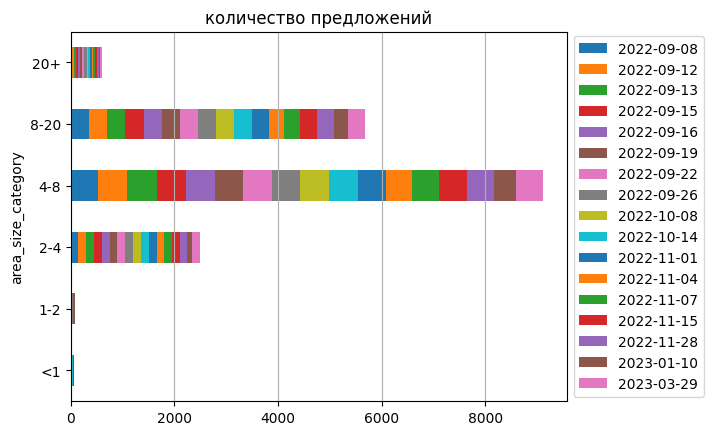

In [18]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

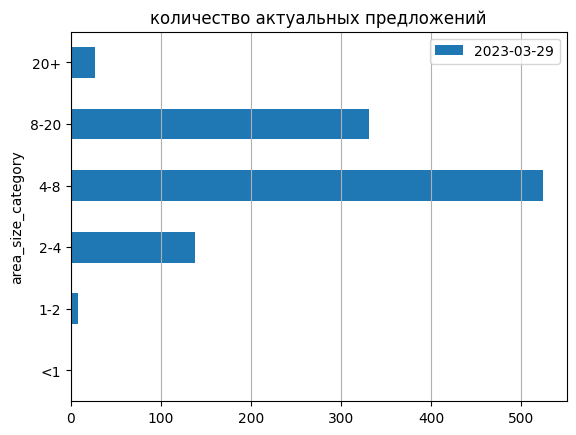

In [19]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений',)#  stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [20]:
stat = gdf.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9])

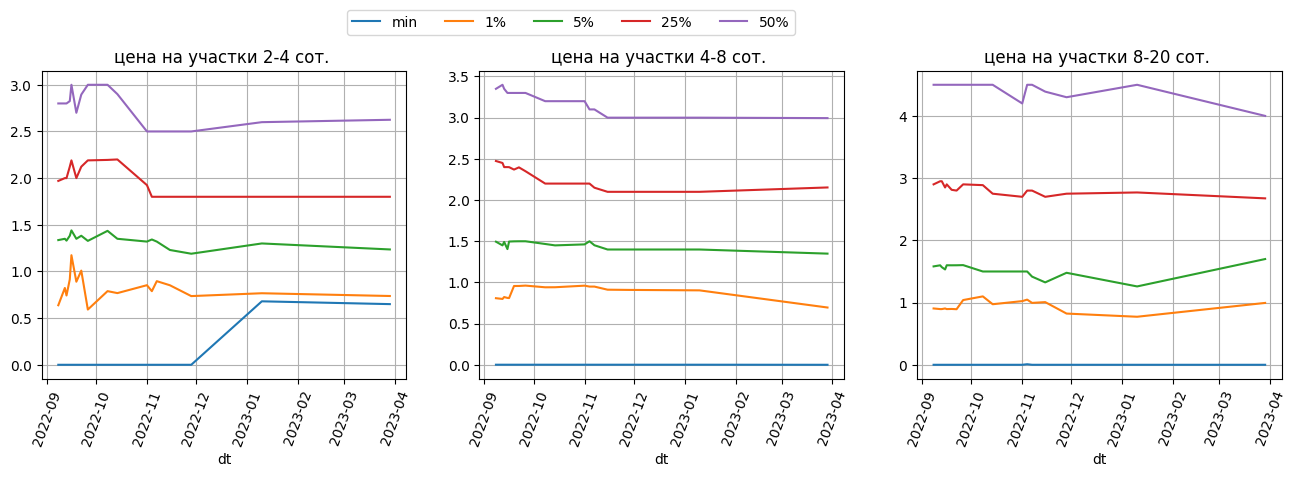

In [21]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','5%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i], legend=False,rot=70)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

In [22]:
stat = stat.reset_index()
dtm = stat['dt'].max()
stat[stat['dt']==dtm][['area_size_category','min','1%','5%','25%','50%','75%','90%','max']]

,area_size_category,min,1%,5%,25%,50%,75%,90%,max
16,<1,0.30,0.45,1.03,3.97,7.65,11.32,13.53,15.00
33,1-2,0.60,0.60,0.62,0.99,1.65,4.38,11.50,15.00
50,2-4,0.65,0.74,1.24,1.80,2.62,3.97,5.03,8.90
67,4-8,0.00,0.70,1.35,2.15,2.99,4.30,6.40,70.00
84,8-20,0.00,0.99,1.70,2.67,4.00,6.50,11.00,60.00
101,20+,3.00,4.04,7.15,10.75,21.00,47.50,72.80,120.00


### гексагональная сетка и медиана актуальной цены

In [23]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

In [24]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [25]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
14,862d28b17ffffff,"POLYGON ((33.85210 44.65544, 33.83059 44.62609, 33.85737 44.59725, 33.90563 44.59776, 33.92716 44.62711, 33.90040 44.65595, 33.85210 44.65544))"
17,862d2884fffffff,"POLYGON ((33.78229 44.62555, 33.76080 44.59617, 33.78760 44.56734, 33.83587 44.56788, 33.85737 44.59725, 33.83059 44.62609, 33.78229 44.62555))"


In [26]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [27]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [28]:
frames.explore('area_name')

In [29]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

18038
586


In [30]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[ gdf_['dt']==gdf_['dt'].max() ][cols].explore( 'area_size_category',legend=True)

In [31]:
locations = ' | '.join(area_name)
locations

'Севастополь, кр.горка'

### количество предложений

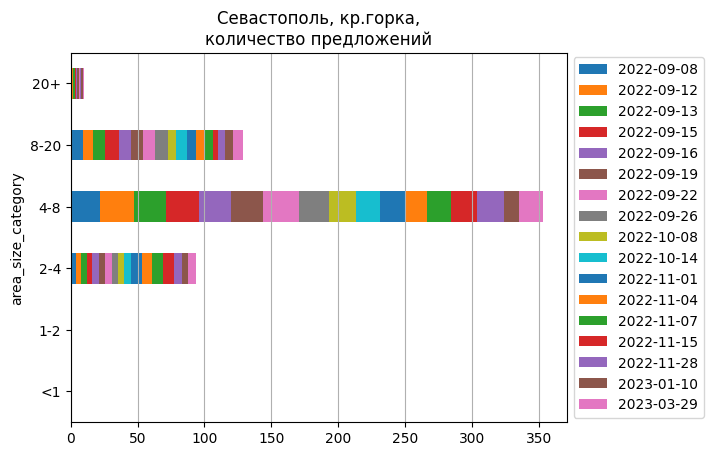

In [32]:
fig = ( # количество предложений
        gdf_
        .groupby(['dt','area_size_category'])
        .size().reset_index()
        .pivot(index='area_size_category', columns='dt', values=0)
        .plot
        .barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
    )
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')


In [33]:
# ( 
#     gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
#     .groupby(['dt','area_size_category'])
#     .size().reset_index()
#     .pivot(index='area_size_category', columns='dt', values=0)
# )#.info()

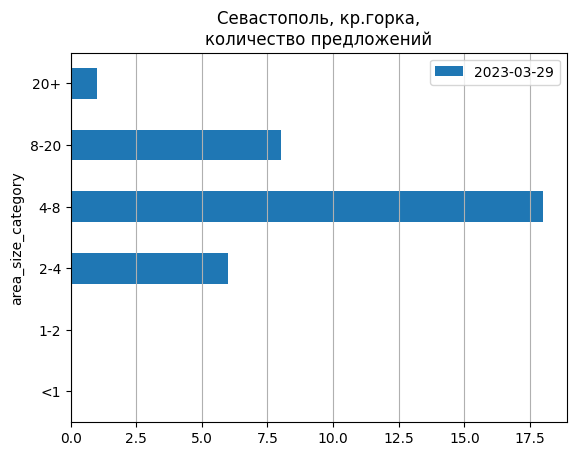

In [34]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot.barh( legend=False,title=f'{locations},\nколичество предложений')#, stacked=True )
)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [39]:
stat = gdf_.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9])

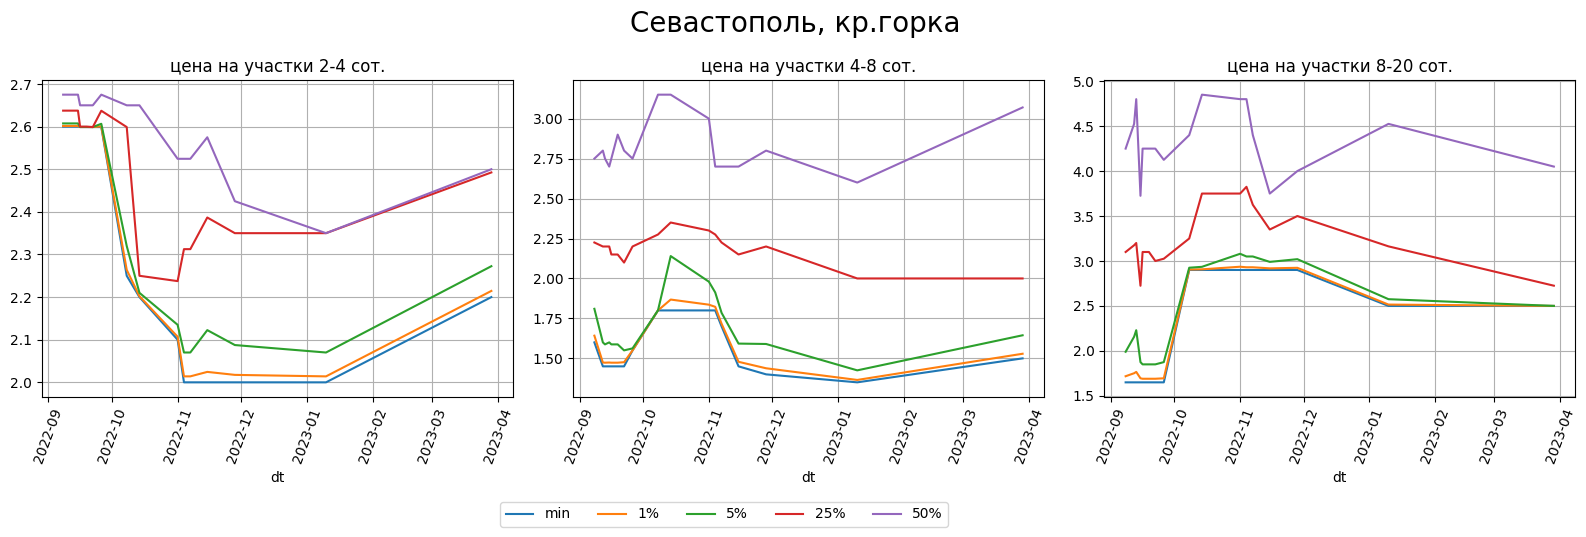

In [40]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','5%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)

fig, ax = plt.subplots(1,len(sizes),figsize=(16,5), sharey=False) #,title=locations)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(
        grid=True, 
        title=f'цена на участки {s} сот.',
        ax=ax[i], 
        legend=False,
        rot=70,
    )
fig.suptitle(locations, fontsize=20)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()
# plt.show()

In [41]:
stat = stat.reset_index()
dtm = stat['dt'].max()
stat[stat['dt']==dtm][['area_size_category','min','1%','5%','25%','50%','75%','90%','max']]

,area_size_category,min,1%,5%,25%,50%,75%,90%,max
16,2-4,2.20,2.21,2.27,2.49,2.50,2.50,2.58,2.65
33,4-8,1.50,1.53,1.64,2.00,3.07,4.45,5.06,6.70
50,8-20,2.50,2.50,2.50,2.72,4.05,4.43,6.90,12.50
60,20+,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00


### гексагональная сетка и медиана актуальной цены

In [37]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
28,892d289406fffff,"POLYGON ((33.53239 44.58973, 33.53206 44.58794, 33.53415 44.58677, 33.53656 44.58740, 33.53688 44.58919, 33.53480 44.59035, 33.53239 44.58973))"
9,892d2895c97ffff,"POLYGON ((33.54842 44.57685, 33.54809 44.57506, 33.55018 44.57390, 33.55259 44.57453, 33.55291 44.57632, 33.55083 44.57748, 33.54842 44.57685))"


In [38]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt'] == gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)